In [1]:
# Load modules
import numpy as np
import psyplot.project as psy
import cmcrameri.cm as cmc
import cartopy.feature as cf
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import sys

# To work with self-written modules, the paths of the modules directories have to be added
icon_vis_dir = Path.cwd().parent
sys.path.insert(1,str(Path(icon_vis_dir,'data')))
sys.path.insert(1,str(Path(icon_vis_dir,'modules')))
from get_data import get_data
from utils import get_stats, add_coordinates, wilks

In [2]:
# Get example datasets for testing (won't do anything if data is already downloaded)
get_data()

In [3]:
f1 = '../data/lfff00000000_cpu.nc'
f2 = '../data/lfff00000000_gpu.nc'

data1 = psy.open_dataset(f1)
data2 = psy.open_dataset(f2)

In [4]:
# Calculate mean, difference and p-values
var = 'lpi'
var1_mean,var2_mean,var_diff,var_pval=get_stats(data1[var].values[:,:],data2[var].values[:,:])

In [5]:
# Create new dataset, which contains the mean var_diff values
data3 = xr.Dataset(
     data_vars=dict(
         var_diff=(["ncells"], var_diff)
     ),
     coords=dict(
         clon=(["ncells"], data1.clon.values[:]),
         clon_bnds=(["ncells","vertices"], data1.clon_bnds.values[:]),
         clat=(["ncells"], data1.clat.values[:]),
         clat_bnds=(["ncells","vertices"], data1.clat_bnds.values[:]),
         time=(["time"], data1.time.values[:]),
     )
 )
data3["clon"].attrs["bounds"] = "clon_bnds"
data3["clat"].attrs["bounds"] = "clat_bnds"
data3["clon"].attrs["units"] = "radian"
data3["clat"].attrs["units"] = "radian"
data3.var_diff.encoding['coordinates'] = 'clat clon'

In [6]:
# show figures after they are drawn or updated
psy.rcParams['auto_show'] = True
%matplotlib inline
%config InlineBackend.close_figures = False

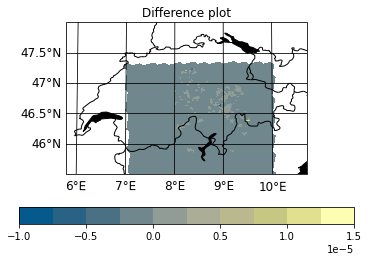

In [7]:
# create psyplot instance
# name: name of variable
# projection: e.g. robin
# title: title of plot
# map_extent: borders of map (example for Switzerland)
lonmin = 5.8
lonmax = 10.7
latmin = 45.5
latmax = 48.0

pp = psy.plot.mapplot(data3,
    name = 'var_diff',
    projection = 'robin',
    map_extent = [lonmin, lonmax, latmin, latmax],
    title = 'Difference plot',
    cmap = 'cmc.nuuk')

# Add borders and lakes with cartopy
ax = pp.plotters[0].ax
resol = '10m'
lakes = cf.NaturalEarthFeature(category='physical', name='lakes', scale=resol, edgecolor='k', facecolor='k')
ax.add_feature(cf.BORDERS)
ax.add_feature(lakes);

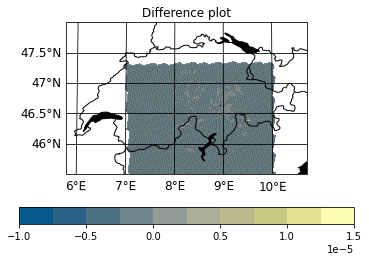

In [8]:
# Add dots for insignificant values
lats = np.rad2deg(data3.clat.values[:])
lons = np.rad2deg(data3.clon.values[:])
pos_lon,pos_lat = add_coordinates(lons,lats,lonmin,lonmax,latmin,latmax)

fig = plt.gcf()
pval_insig = np.argwhere((np.isnan(var_pval)) | (var_pval>0.05))
for i in pval_insig:
    fig.axes[0].plot(pos_lon[i], pos_lat[i],'k',marker='.', markersize=0.1, transform=fig.axes[0].transAxes)
pp.update()

In [9]:
# Account for dependency of data points
alpha = 0.05
pfdr = wilks(var_pval, alpha)

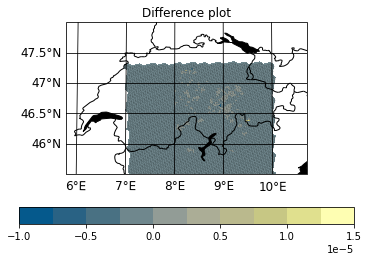

In [10]:
pp_new = psy.plot.mapplot(data3,
    name = 'var_diff',
    projection = 'robin',
    map_extent = [lonmin, lonmax, latmin, latmax],
    title = 'Difference plot',
    cmap = 'cmc.nuuk')

# Add borders and lakes with cartopy
ax = pp_new.plotters[0].ax
resol = '10m'
lakes = cf.NaturalEarthFeature(category='physical', name='lakes', scale=resol, edgecolor='k', facecolor='k')
ax.add_feature(cf.BORDERS)
ax.add_feature(lakes)

fig = plt.gcf()
pfdr_insig = np.argwhere((np.isnan(var_pval)) | (var_pval>pfdr))
for i in pfdr_insig:
    fig.axes[0].plot(pos_lon[i], pos_lat[i],'k',marker='.', markersize=0.1, transform=fig.axes[0].transAxes)